## Frame

In [1]:
using Gridap
using Plots
using GridapMakie
using CairoMakie 
using GLMakie
using Gridap.Geometry
using GridapGmsh
using WriteVTK
using Gmsh: Gmsh, gmsh

In [2]:
# Initialize the Gmsh API
gmsh.initialize()

# Open the .geo file
geo_file = "./msh_files/OFFSHORE_NASAL_JACKET.geo"
gmsh.open(geo_file)

# Set options to ensure lines are not subdivided
gmsh.option.set_number("Mesh.ElementOrder", 1)

# println("Mesh saved as $msh_file")

Info    : Reading './msh_files/OFFSHORE_NASAL_JACKET.geo'...
Info    : Done reading './msh_files/OFFSHORE_NASAL_JACKET.geo'


In [3]:
gmsh.option.set_number("Mesh.CharacteristicLengthMax", 1)
gmsh.option.set_number("Mesh.CharacteristicLengthMin", 1)

# Generate the mesh
gmsh.model.mesh.generate(1)  # Generate a 1D mesh (the physical elements are 1D (!))

# Save as .msh file
msh_file = "./msh_files/OFFSHORE_NASAL_JACKET.msh"
gmsh.write(msh_file)

# Finalize Gmsh
gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 30%] Meshing curve 7 (Line)
Info    : [ 30%] Meshing curve 8 (Line)
Info    : [ 30%] Meshing curve 9 (Line)
Info    : [ 40%] Meshing curve 10 (Line)
Info    : [ 40%] Meshing curve 11 (Line)
Info    : [ 50%] Meshing curve 12 (Line)
Info    : [ 50%] Meshing curve 13 (Line)
Info    : [ 50%] Meshing curve 14 (Line)
Info    : [ 60%] Meshing curve 15 (Line)
Info    : [ 60%] Meshing curve 16 (Line)
Info    : [ 60%] Meshing curve 17 (Line)
Info    : [ 70%] Meshing curve 18 (Line)
Info    : [ 70%] Meshing curve 19 (Line)
Info    : [ 80%] Meshing curve 20 (Line)
Info    : [ 80%] Meshing curve 21 (Line)
Info    : [ 80%] Meshing curve 22 (Line)
Info    : [ 90%] Meshing curve 23 (Line)
Info    : [ 90%] Meshing curve 24 (Line)
I

In [69]:
# Define known parameters/functions for the rod equation
E = 2e10 # Young's modulus of steel (Pa)
ρ = 7850 # Density of steel (kg/m3)

# Nacelle
M_Nacelle = 5000 # kg

# Pile 
m_Pile(x) = 1000 # kg/m
EA_Pile = 1e8 # N 

# Jacket 
m_Jacket(x) = 100 # N/m 
EA_Jacket = 1e6 # N

# Define the known parameters/functions for the Timoschenko beam equation
ν = 0.2 # Poisson's ratio
EI_Pile = 1e9 # Nm2
EI_Jacket = 1e7 # Nm2

G = E/(2*(1+ν)) # Shear modulus (Pa)
GA_Jacket = G*(EA_Jacket/E) # Shear stiffness of jacket elements (N)
GA_Pile = G*(EA_Pile/E) # Shear stiffness of pile elements (N)

ρI_Jacket = ρ*(EI_Jacket/E)
ρI_Pile = ρ*(EI_Pile/E)

ρA_Jacket = ρ*(EA_Jacket/E)
ρA_Pile = ρ*(EA_Pile/E)

# Define load parameters
f0 = 2                          # [Hz]
A0 = 0.1                        # [m]
T0 = 20                         # [s]

# Define the support earthquake function
v_ext(t) = A0*sin(2*π*f0*t)   # [m]

model = GmshDiscreteModel("msh_files/OFFSHORE_NASAL_JACKET.msh")

Info    : Reading 'msh_files/OFFSHORE_NASAL_JACKET.msh'...
Info    : 48 entities
Info    : 446 nodes
Info    : 456 elements
Info    : Done reading 'msh_files/OFFSHORE_NASAL_JACKET.msh'


UnstructuredDiscreteModel()

In [70]:
# Set up the figure and axis 
labels = get_face_labeling(model)
initial_tags = get_tag_entities(labels)[end]
tag_from_names = get_tag_from_name(labels)

Dict{String, Int64} with 5 entries:
  "Jacket Members" => 4
  "Pile Members"   => 5
  "Supports"       => 1
  "Bottom Pile"    => 3
  "Nacelle"        => 2

In [36]:
# Set up the figure and axis 
fig = Figure(resolution=(800, 600))
ax = Axis(fig[1, 1], title="Domain with Boundary Tags", xlabel="x", ylabel="y")

for intgr in length(tag_from_names)
    CairoMakie.wireframe!(ax, Triangulation(model))
end

CairoMakie.scatter!(ax, Boundary(Triangulation(model), tags="Supports"))
CairoMakie.scatter!(ax, Boundary(Triangulation(model), tags="Nacelle"))
CairoMakie.scatter!(ax, Boundary(Triangulation(model), tags="Jacket Members"))
CairoMakie.scatter!(ax, Boundary(Triangulation(model), tags="Pile Members"))

fig

In [72]:
Ω = Triangulation(model)
Ω_pile = Triangulation(model, tags="Pile Members")
Ω_jacket = Triangulation(model, tags="Jacket Members")
Γ_S = Boundary(Ω_jacket,tags="Supports")
Γ_N = Boundary(Ω_pile,tags="Nacelle")

CompositeTriangulation()

In [ ]:
# Transient problem
order = 2
reffe_u = ReferenceFE(lagrangian, Float64, order) # We create a Reference Finite Element (it serves as a basis function on one single triangulation element (puzzle piece of the entire puzzle))
reffe_v = ReferenceFE(lagrangian, Float64, order) 
reffe_θ = ReferenceFE(lagrangian, Float64,order)

u_Y = TestFESpace(Ω, reffe_u; conformity=:H1, dirichlet_tags="Supports") # The TestFESpace for the rod equation
u_X = TransientTrialFESpace(u_Y) # The TrialFESpace for the rod equation

v_Y = TestFESpace(Ω, reffe_v; dirichlet_tags="Supports") # The TestFESpace for the displacement in Timoschenko equation
θ_Y = TestFESpace(Ω, reffe_θ; dirichlet_tags="Supports") # The TestFESpace for the rotation in Timoschenko equation 

v_X = TransientTrialFESpace(v_Y, v_ext) # The TestFESpace for the displacement in Timoschenko equation
θ_X = TransientTrialFESpace(θ_Y) # The TestFESpace for the rotation in Timoschenko equation 

X = TransientMultiFieldFESpace([v_X,θ_X])
Y = MultiFieldFESpace([v_Y,θ_Y])

MultiFieldFESpace()

In [101]:
degree = 2*order # Degree of the quadrature rule to prevent shear locking
dΩ_Pile = Measure(Ω_pile, degree) # Numerical integration within the domain Ω using second-order Gaussian quadrature rule
dΩ_Jacket = Measure(Ω_jacket, degree) # Numerical integration within the domain Ω using second-order Gaussian quadrature rule
dΓ_N = Measure(Γ_N,degree) # Numerical integration along the Neumann boundary Γ_D using second-order Gaussian quadrature rule
nΓ_N = get_normal_vector(Γ_N) # Normal vector to the Neumann boundary Γ_N
dΓ_S = Measure(Γ_S,degree) # Numerical integration along the supports Γ_S using second-order Gaussian quadrature rule
nΓ_S = get_normal_vector(Γ_S) # Normal vector to the supports Γ_S

GenericCellField():
 num_cells: 2
 DomainStyle: ReferenceDomain()
 Triangulation: CompositeTriangulation()
 Triangulation id: 13686802527524347982

In [ ]:
m_rod(t, dttu, h) = ∫(m_Pile * dttu · h)dΩ_Pile + ∫(m_Jacket * dttu · h)dΩ_Jacket
c_rod(t, dtu, h) = ∫(0 * dtu ⋅ h)dΩ_Pile + ∫(0 * dtu ⋅ h)dΩ_Jacket
a_rod(t, u, h) = ∫(EA_Pile * ∇(u) ⋅ ∇(h))dΩ_Pile + ∫(EA_Jacket * ∇(u) ⋅ ∇(h))dΩ_Jacket
l_rod(t, h) = ∫(-M_Nacelle*9.81*h)dΓ_N + ∫(0 * h)dΩ_Jacket + ∫(0 * h)dΩ_Pile

# Updated bilinear form including time-dependent mass terms
m_timo(t, (dttv, dttθ), (w,ψ)) = ∫(ρI_Jacket * dttθ ⋅ ψ)dΩ_Jacket + ∫(ρI_Pile * dttθ ⋅ ψ)dΩ_Pile + 
                                ∫(ρA_Jacket * dttv ⋅ w)dΩ_Jacket  + ∫(ρA_Pile * dttv ⋅ w)dΩ_Pile +
                                ∫(M_Nacelle*dttv⋅w)dΓ_N

c_timo(t, (dtv, dtθ),  (w,ψ)) = ∫(0*dtv⋅w)dΩ_Jacket + ∫(0*dtv⋅w)dΩ_Pile

a_timo(t, (v,θ), (w,ψ)) = ∫(EI_Jacket*(∇(θ)⊙∇(ψ)) + GA_Jacket* ((∇(v)-θ)⋅(∇(w)-ψ)) )dΩ_Jacket +
                      ∫(EI_Pile*(∇(θ)⊙∇(ψ)) + GA_Pile*((∇(v)-θ)⋅(∇(w)-ψ)) )dΩ_Pile

# Updated linear form for transient external forces
l_timo(t, (w,ψ)) = ∫(0 * w)dΓ_N

op_rod = TransientAffineFEOperator(m_rod, c_rod, a_rod, l_rod, u_X,u_Y)
op_timo = TransientAffineFEOperator(m_timo, c_timo, a_timo, l_timo,X,Y)

TransientFEOperatorFromWeakForm()

In [108]:
# Solution
γₜ = 0.5
βₜ = 0.25
ls = LUSolver()
Δt = 0.05
ode_solver = Newmark(ls,Δt,γₜ,βₜ)

# Time interval
t0, tF = 0.0, 10.0

# Initial solution
x0_rod = interpolate_everywhere(0.0,u_X(0.0))
v0_rod = interpolate_everywhere(0.0,u_X(0.0))
a0_rod = interpolate_everywhere(0.0,u_X(0.0))

x0_timo = interpolate_everywhere([0.0,0.0],X(0.0))
v0_timo = interpolate_everywhere([0.0,0.0],X(0.0))
a0_timo = interpolate_everywhere([0.0,0.0],X(0.0))

xt_rod = solve(ode_solver,op_rod,(x0_rod,v0_rod,a0_rod),t0,tF)
xt_timo = solve(ode_solver,op_timo,(x0_timo,v0_timo,a0_timo),t0,tF)

Gridap.ODEs.TransientFETools.TransientFESolution(GenericODESolution(), TransientMultiFieldTrialFESpace{Gridap.MultiField.ConsecutiveMultiFieldStyle, Gridap.FESpaces.UnConstrained, Vector{Float64}}(Vector{Float64}, Any[TransientTrialFESpace{Gridap.FESpaces.UnconstrainedFESpace{Vector{Float64}, Nothing}, TrialFESpace{Gridap.FESpaces.UnconstrainedFESpace{Vector{Float64}, Nothing}}}(UnconstrainedFESpace(), v_ext, TrialFESpace()), TrialFESpace()], Gridap.MultiField.ConsecutiveMultiFieldStyle(), Gridap.FESpaces.UnConstrained()))

In [109]:
# ls = LUSolver()
# Δt = 0.05
# θ = 0.5
# solver = ThetaMethod(ls, Δt, θ)

# # Time interval
# t0, tF = 0.0, 10.0

# # Initial solution
# x0 = interpolate_everywhere([0.0,0.0,0.0],X(0.0))

# xt = solve(solver,op,x0,t0,tF)

In [110]:
Ω = Triangulation(model) # The domain Ω is the entire mesh (jacket + pile)

output_dir = "results/"
vtk_output = true

output_dir = "results/"
vtk_output = true
if vtk_output == true
    pvd_u = paraview_collection(output_dir * "_u_solution", append=false)
    pvd_v = paraview_collection(output_dir * "_v_solution", append=false)
    pvd_theta = paraview_collection(output_dir * "_theta_solution", append=false)
  end

# Time stepping for visualization
times = t0:Δt:tF

Nacelle_u = []

for (u, t) in xt_rod
  # Write to VTK
  push!(Nacelle_u, evaluate(u, Gridap.Point(0.0, 0.0)))
  if vtk_output == true
      pvd_u[t] = createvtk(Ω,output_dir * "_u_solution" * "_$t.vtu",cellfields = ["u" => u])#,nsubcells=10)
    end
end

Nacelle_v = []
Nacelle_theta = []

Nacelle_v_pile = []
Nacelle_v_jacket = []

for ((v,θ), t) in xt_timo
    # Write to VTK
    push!(Nacelle_v, evaluate(v, Gridap.Point(0.0, 100.0)))
    push!(Nacelle_theta, evaluate(θ, Gridap.Point(0.0, 100.0)))

    push!(Nacelle_v_pile, evaluate(v, Gridap.Point(0.0, 0.1)))
    push!(Nacelle_v_jacket, evaluate(v, Gridap.Point(0.01, 0.0)))
    if vtk_output == true
        pvd_v[t] = createvtk(Ω,output_dir * "_v_solution" * "_$t.vtu",cellfields = ["v" => v],nsubcells=10)
        pvd_theta[t] = createvtk(Ω,output_dir * "_theta_solution" * "_$t.vtu",cellfields = ["theta" => θ],nsubcells=10)
      end
end

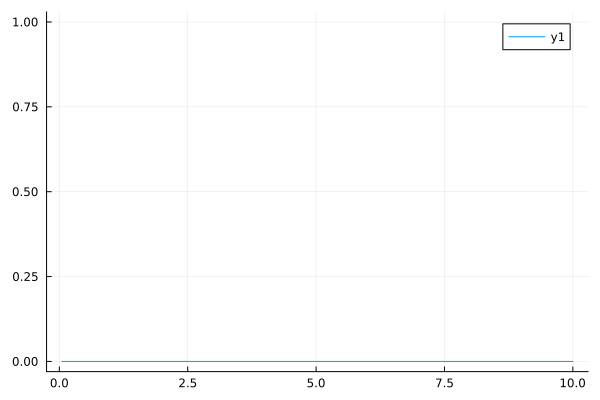

In [113]:
Plots.plot(times[2:end], Nacelle_u)

## Eigenmodes analysis

In [452]:
# Weak form
a((v,θ), (w,ψ)) = ∫( EI_Jacket*(∇(θ)⊙∇(ψ)) + GA*((∇(v)-θ)⋅(∇(w)-ψ)) )dΩ_Jacket + ∫( EI_Pile*(∇(θ)⊙∇(ψ)) + GA*((∇(v)-θ)⋅(∇(w)-ψ)) )dΩ_Pile

l((w,ψ)) = ∫(0.0*h)dΩ_Jacket + ∫(0.0*h)dΩ_Pile + ∫(0.0*w)dΓ_N

matrix_of_sys = get_matrix(AffineFEOperator(a, l, X, Y ))

In [40]:
using LinearAlgebra, SparseArrays, Arpack

In [43]:
# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = eigs(matrix_of_sys)[1], eigs(matrix_of_sys)[2]

([8.129138942699124e10, 6.671749422231313e10, 5.361642160505554e10, 3.3567172348623577e10, 3.2364744020012268e10, 2.913722489771512e10], [-1.0139340933264313e-16 1.6835705259791312e-17 … 1.2788716474302897e-16 -2.242473889406867e-16; 1.648300351033481e-17 -8.004338020742087e-18 … -2.357134569644194e-17 5.4603040653209694e-17; … ; -0.002264403794857761 -0.008012440908929067 … -0.03390491928295151 0.02534166231878565; -0.02282381237761666 -0.06327081232182952 … 0.04895720763699857 -0.06273962324810721])

In [55]:
# Interpolation into FESpace
u_interp = FEFunction(v_X, eigenvectors[10:18,2])

# Export to VTK
writevtk(
    Ω,
    "eigenmodes_frame/eigenmodes",  # Output filename
    cellfields = ["Eigenmode1" => u_interp]
)

(["eigenmodes_frame/eigenmodes.vtu"],)